## Continuous Optimization in One Region and Time Period

This model represents the beginnings of a new *continuous* MINIMOD opimizer that chooses the amount of fortificant to put into a nutritional intervention. 

What this model does:

- Given data on fortificant levels, activity levels, calculates the premix cost for different levels of premix and fits a line it
- Given data on benefits across different levels of fortificant, fits a logistic curve to that data
- Optimizes the cost function subject to the benefit function and non-negativity constraints

What this model doesn't do:

- takes into account the UL
- takes into account space and time
- takes into account interactions of interventions (this still needs to be done on the SIMPLE macro level)
- dynamics/nutrient build-up 
    - This might be potentially interesting in the case of a particular biological mechanism that constrains how much of a vitamin can be given

Next Steps:

- Incorporate space and time
    - dynamics?
    - space-time specific benefit/cost functions?

In [1]:
from example_data import df
import pandas as pd
import numpy as np
from minimod_opt.continuous.optimize import ContinuousOptimizer

cdf = pd.read_csv("cost_data.csv")

## Trying with real data

df_real = pd.read_csv("/home/lordflaron/Documents/minimod/examples/data/processed/example1.csv")

df_real = (
    df_real
    .loc[lambda df: df['space'] == 'Cities']
    .loc[lambda df: df['time']==4]
    .loc[lambda df: df['intervention'].isin(['cube', 'maize', 'oil'])]
    .replace({'intervention' : {'oil' : 'Refined Oil',
                                'cube' : 'Bouillon',
                                'maize' : 'Maize Flour'}})
    .rename({'intervention' : 'vehicle'}, axis=1)
)
increment= np.linspace(0,500,100)

func_benefits = lambda x, L, k, x0: L/(1 + np.exp(-k*(x - x0)))

np.random.seed(1729)

df_incremented = pd.DataFrame()

for i, col in df_real.iterrows():
    
    noise = 0.2 * np.random.normal(loc=10000000, scale = 70000, size=increment.size)
    benefits = func_benefits(increment, col['benefit'], .1, 100) + noise

    benefits_true = func_benefits(increment, col['benefit'], .1, 100)
    
    df = pd.DataFrame({'increment' : increment,
                        'benefit' : benefits,
                        'benefits_true' : benefits_true,
                        'vehicle' : col['vehicle']})
    df_incremented = df_incremented.append(df)




/usr/lib/python3.9/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### The Data

The data is take from the Cameroon data for a subset of interventions in some period (T=4) in some region (Cities).

These logistic curves are based on real data on effective coverage.



In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

# px.scatter(df_incremented, x= 'increment', y = 'benefit', color='vehicle')
px.line(df_incremented, x= 'increment', y = 'benefits_true', color='vehicle')



### Vehicles and Nutrient Choices

The Continuous Optimizer's main change in data requirements is in the costs. Instead of just getting data on the costs across space and time, the optimizer will also need information on the nutrient composition of an intervention, which nutrients are being changed, and the premix cost calculator for it.

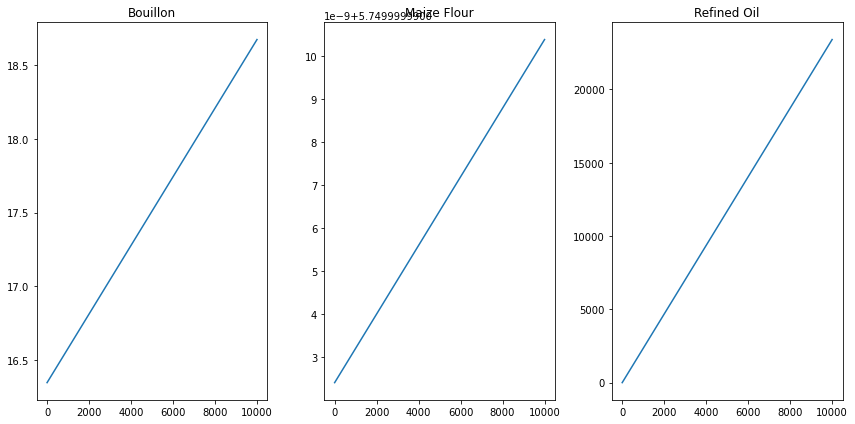

In [15]:
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(12,6))

vehicle_dict = {
    "Bouillon": [
        ("Iron", "Micronized ferric pyrophosphate"),
        ("Vitamin A", "Retinyl Palmitate- 250,000 IU/g (dry)"),
        ("Zinc", "Zinc Oxide"),
        ("Vitamin B12", "Vit. B-12 0.1% WS"),
        ("Folic Acid", "Folic Acid"),
    ],
    "Maize Flour": [("Iron", "Ferrous Fumarate"),
                    ('Folic Acid', 'Folic Acid')],
    'Refined Oil' : [('Vitamin A', 
                        "Retinyl Palmitate- 1.7 m IU/g (oil)")]
    
}


nutrient_choice = {"Bouillon": "Zinc", 
                    "Maize Flour": "Iron",
                    'Refined Oil' : 'Vitamin A'}

c = ContinuousOptimizer(
    vehicle_dict=vehicle_dict,
    benefit_data=df_incremented,
    cost_data=cdf,
    benefit_col="benefits_true",
    increment_col="increment",
    vehicle_col="vehicle",
    fortificant_col="compound",
    activity_col="fort_prop",
    overage_col="fort_over",
)



ax1.plot(np.linspace(0,10000,10), c.data(nutrient_choice)['cost_fit'][0](np.linspace(0,10000,10)))
ax1.set_title('Bouillon')
ax2.plot(np.linspace(0,10000,10), c.data(nutrient_choice)['cost_fit'][1](np.linspace(0,10000,10)))
ax2.set_title("Maize Flour")
ax3.plot(np.linspace(0,10000,10), c.data(nutrient_choice)['cost_fit'][2](np.linspace(0,10000,10)))
ax3.set_title("Refined Oil")

plt.tight_layout()

### The Optimization

For this example, we will choose the mg/kg of the three interventions above, minimizing costs, subject to a minimum benefits of 90,000 children effectively covered.

In [7]:
res = c.optimize(nutrient_choice, 90000, [100,100,100], basin=True)

basinhopping step 0: f 23.5832
basinhopping step 1: f 23.5832 trial_f 23.5832 accepted 1  lowest_f 23.5832
basinhopping step 2: f 23.5831 trial_f 23.5831 accepted 1  lowest_f 23.5831
found new global minimum on step 2 with function value 23.5831
basinhopping step 3: f 23.583 trial_f 23.583 accepted 1  lowest_f 23.583
found new global minimum on step 3 with function value 23.583
basinhopping step 4: f 23.583 trial_f 23.583 accepted 1  lowest_f 23.583
found new global minimum on step 4 with function value 23.583
basinhopping step 5: f 23.5831 trial_f 23.5831 accepted 1  lowest_f 23.583
basinhopping step 6: f 23.583 trial_f 23.583 accepted 1  lowest_f 23.583
basinhopping step 7: f 23.5829 trial_f 23.5829 accepted 1  lowest_f 23.5829
found new global minimum on step 7 with function value 23.5829
basinhopping step 8: f 23.5828 trial_f 23.5828 accepted 1  lowest_f 23.5828
found new global minimum on step 8 with function value 23.5828
basinhopping step 9: f 23.5827 trial_f 23.5827 accepted 1 

In [16]:
res.x

array([52.98580022, 80.10404441,  0.        ])